In [1]:
import os
import torchaudio
import torch
import matplotlib.pyplot as plt
from torch.nn import Module, Linear, Sigmoid, LSTM, BCELoss
from torch.optim import Adam
import torch.nn.functional as F
from pytorch_model_summary import summary
from tqdm import tqdm
import numpy as np

In [3]:
from DataLoader import DataLoaderAll

X,Y,speech,mix1,X_complex = DataLoaderAll.data_loader(n_noise=100)

# MaskNet + Training

In [4]:
# MASK NET
HIDDEN_SIZE=1024 # 128
SAMPLE_RATE = 16000
INPUT_CHANNEL = 4 # Always two -> Real and Imaginary part 

class MaskNet(Module):
    def __init__(self,noise=False):
        super(MaskNet, self).__init__()
        # First subnet for speech prediction
        self.noise = noise
        self.lstm = LSTM(input_size=INPUT_CHANNEL, hidden_size=HIDDEN_SIZE, num_layers=2, bidirectional=True)
        self.fc = Linear(in_features=HIDDEN_SIZE*2 ,out_features=1)
        self.sigmoid = Sigmoid()
        # # Second subnet for noise prediction
        # self.noise2 = noise
        # self.lstm2 = LSTM(input_size=INPUT_CHANNEL, hidden_size=HIDDEN_SIZE, num_layers=2, bidirectional=True)
        # self.fc2 = Linear(in_features=HIDDEN_SIZE*2 ,out_features=1)
        # self.sigmoid2 = Sigmoid()

    def forward(self,x):
        # Speech prediction
        y, (h_n, c_n) = self.lstm(x)
        y = self.fc(y)
        speech_pred = self.sigmoid(y)
        return speech_pred.reshape(513,-1)#, noise_pred

print(summary(MaskNet(),torch.zeros((513, 196, 4))))

--------------------------------------------------------------------------------------------------------
      Layer (type)                                         Output Shape         Param #     Tr. Param #
            LSTM-1     [513, 196, 2048], [4, 196, 1024], [4, 196, 1024]      33,619,968      33,619,968
          Linear-2                                        [513, 196, 1]           2,049           2,049
         Sigmoid-3                                        [513, 196, 1]               0               0
Total params: 33,622,017
Trainable params: 33,622,017
Non-trainable params: 0
--------------------------------------------------------------------------------------------------------


In [5]:
EPOCHS = 5
LEN_TRAIN = 2000
NUM_CHANNEL = 2 # Number of Mic Inputs (>=2 for BF)
REFERENCE_CHANNEL = 0
INIT_LR = 0.0001
BATCH_SIZE = 1#64
LEARN_LOSS_PARAMS = False
device =  torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

model = MaskNet().to(device)
model= torch.nn.DataParallel(model,device_ids=[3])

lossBCE = BCELoss()

opt = Adam(model.parameters(), lr=INIT_LR)

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

def check_accuracy_training(speech_pred, y_s):
    speech_pred = (speech_pred>0.15).float()
    return float(torch.sum((speech_pred == y_s).float())/torch.sum(torch.ones(513,speech_pred.shape[1])))

def check_accuracy_validation(model):
    example_nr = int(np.random.random()*(len(X)-LEN_TRAIN)+LEN_TRAIN)
    model.eval()
    pred = model(X[example_nr])
    val_loss = lossBCE(pred,Y[example_nr][0])
    pred = (pred>0.15).float()
    model.train()
    return float(torch.sum((pred == Y[example_nr][0]).float())/torch.sum(torch.ones(513,X[example_nr].shape[1]))),val_loss

print("[INFO] training the network...")
#X = stft_mix[:50].to(device)
#Y = Y.to(device)
X = X.to(device)
Y = Y.to(device)
trainX = X[:LEN_TRAIN]
trainY = Y

for epoch in range(0, EPOCHS):
    print("Epoch:",str(epoch+1)+"/"+str(EPOCHS))
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    for i in tqdm(range(0,len(trainX))): # Iterate over Training Examples
        y_s = trainY[i][0] # 0 speech only
        x = trainX[i]
        speech_pred=model(x)#, noise_pred = model(x)
        loss = lossBCE(speech_pred,y_s) #+ lossMSE(noise_pred,y_n)
        # zero out the gradients, perform the backpropagation step, and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        H["train_acc"].append(check_accuracy_training(speech_pred,y_s))
        H["train_loss"].append(float(loss))
        if i % 10 == 0:
            val_acc, val_loss = check_accuracy_validation(model)
            H["val_acc"].append(val_acc)
            H["val_loss"].append(float(val_loss))
    # Print results of Epoch        
    print("Average Training Accuracy in Epoch",str(epoch+1),":",np.mean(np.array(H["train_acc"])))
    print("Total Training Loss in Epoch",str(epoch+1),":",np.sum(np.array(H["train_loss"])))
    print("Average Validation Accuracy in Epoch",str(epoch+1),":",np.mean(np.array(H["val_acc"])))
    print("Total Validation Loss in Epoch",str(epoch+1),":",np.sum(np.array(H["val_loss"])))
    # Save Model after Epoch        
    PATH = "./modelsaveLibreOneNoise"
    torch.save(model.state_dict(), PATH + "model_epoch" + str(epoch+1) + ".pt")
    print(totalTrainLoss)

[INFO] training the network...
Epoch: 1/5


 60%|█████▉    | 1199/2000 [37:55<25:20,  1.90s/it] 


KeyboardInterrupt: 

## Load Model & Evaluate

In [5]:
PATH = "modelsaveLibreOneNoisemodel_epoch2.pt"
#device = torch.device('cuda:0')
state_dict = torch.load(PATH)
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.` from state dict
    new_state_dict[name] = v
# load params
model = MaskNet()
model.load_state_dict(new_state_dict)
#model= torch.nn.DataParallel(model)
#model.load_state_dict(torch.load(PATH))#,map_location=device))
#model.to(device)
model.eval()

MaskNet(
  (lstm): LSTM(4, 1024, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

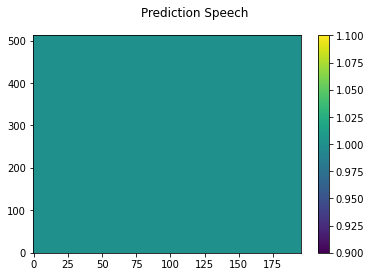

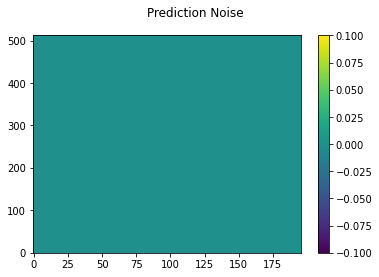

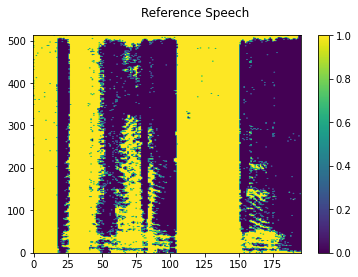

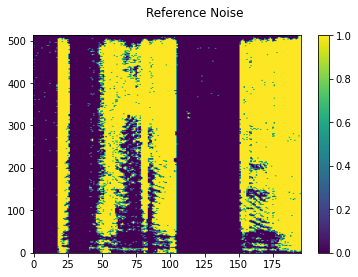

In [6]:
X = X.cpu()
Y = Y.cpu()
def evaluate_example(e_nr):
    model.eval()
    speech_pred = (model(X[e_nr])>0.2).float()
    noise_pred = torch.ones([513,X[e_nr].shape[1]])-speech_pred
    plot_mask(speech_pred, title="Prediction Speech")
    plot_mask(noise_pred, title="Prediction Noise")
    plot_mask(Y[e_nr][0], title="Reference Speech")
    plot_mask(Y[e_nr][1], title="Reference Noise")

def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

evaluate_example(10)

In [ ]:
istft = torchaudio.transforms.InverseSpectrogram(n_fft=1024, hop_length=256)

def evaluateSiSNR(wave, i):
    def si_snr(estimate, reference, epsilon=1e-8):
        estimate = estimate - estimate.mean()
        reference = reference - reference.mean()
        reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
        mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
        scale = mix_pow / (reference_pow + epsilon)

        reference = scale * reference
        error = estimate - reference

        reference_pow = reference.pow(2)
        error_pow = error.pow(2)

        reference_pow = reference_pow.mean(axis=1)
        error_pow = error_pow.mean(axis=1)

        si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
        return si_snr.item()
    score = si_snr(wave, speech[i])
    print(f"Si-SNR score: {score}") 
    return score

def maskToWave(speech_pred,noise_pred,mix,i):
        model.eval()
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix[i], speech_pred)
        psd_noise = psd_transform(mix[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix[i], psd_speech, psd_noise, reference_channel=0)
        waveform_souden = istft(stft_souden, length=len(speech[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)

def save_sample(i,wave,sample_rate=SAMPLE_RATE):
    torchaudio.save("./outputs/output.wav",wave.reshape(1,-1),16000)
    torchaudio.save("./outputs/sample_reference.wav", speech[i].reshape(1,-1),sample_rate)
    torchaudio.save("./outputs/sample_input.wav", mix1[i].reshape(1,-1),sample_rate)

index = 201
speech_pred = (model(X[index])>0.2).float()
noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
wave = maskToWave(speech_pred,noise_pred,X_complex,index)#X hat nicht mehr nur 2, sondern 4 channel
print(wave.shape)
print(wave)
save_sample(index, wave=wave)
score = evaluateSiSNR(wave,index)#Should be ~28

torch.Size([50000])
tensor([ 1.3978e-04, -2.0256e-04, -8.1376e-05,  ...,  1.6835e-03,
         1.8071e-03,  1.8175e-03])
Si-SNR score: 27.374475479125977
